# Tutorial 4
## May 24, 2023
In the previous tutorials, you have familiarized yourself with PyTorch, MONAI, and Weights & Biases. In last week's lectures 4 and 5, you have heard about image reconstruction and image registration with (convolutional) neural networks. This week, you again get the chance to put what you have learned into practice. The tutorial consists of two parts. First, you will develop, train, and evaluate a CNN for denoising of (synthetic) CT images. Second, you will develop, train, and evaluate a CNN that learns to perform deformable image registration in the chest X-ray images that we have also used in the second tutorial. Along the way, there will be questions (❓) and <b style='background-color:rgba(80,255,80,0.4); padding:2px'>
exercises.</b>

First, let's take care of the necessities:
- If you're using Google Colab, make sure to select a GPU Runtime.
- Connect to Weights & Biases using the code below.
- Install a few libraries that we will use in this tutorial.

In [1]:
import os
import wandb

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
wandb.login()

wandb: Currently logged in as: jelmerwolterink. Use `wandb login --relogin` to force relogin


True

In [2]:
!pip install dival
!pip install kornia
!pip install monai

## Part 1: Reconstruction
In the first part of this tutorial, you will reconstruct CT images. To not use too much disk storage, we will synthetise images on the fly using the Deep Inversion Validation Library [(dival)](https://github.com/jleuschn/dival). These are 2D images with $128\times 128$ pixels that contain a random number of ellipses with random sizes and random intensities. 

First, make a dataset of ellipses. This will make an object that we can call for images using a generator. Next, we take a look at what this dataset contains. We will use the <code>generator</code> to ask for a sample. Each sample contains a sinogram and a ground truth (original) synthetic image that we can visualize. You may recall from the lecture that the sinogram is made up of integrals along projections. The horizontal axis in the sinogram corresponds to the location $s$ along the detector, the vertical axis to the projection angle $\theta$.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/0c/Tomographic_fig1.png" width="400px"></img>

In [3]:
import dival

dataset = dival.get_standard_dataset('ellipses', impl='skimage')
dat_gen = dataset.generator(part='train')

Run the cell below to show a sinogram and image in the dataset.

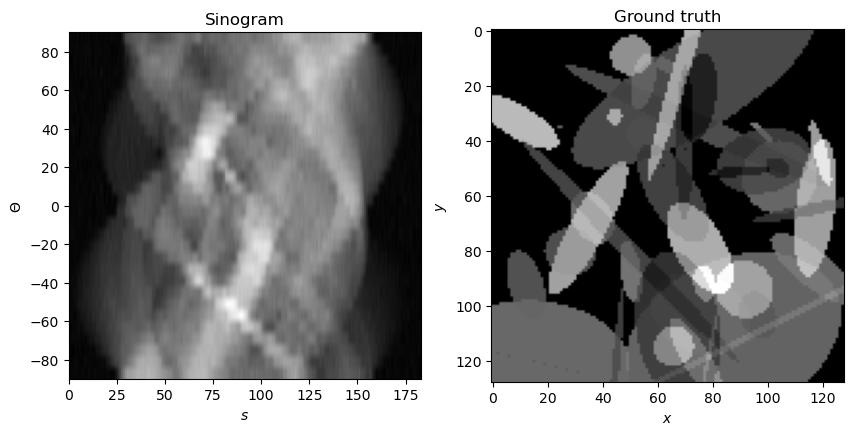

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Get a sample from the generator
sinogram, ground_truth = next(dat_gen)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Show the sinogram
axs[0].imshow(sinogram, cmap='gray', extent=[0, 183, -90, 90])
axs[0].set_title('Sinogram')
axs[0].set_xlabel('$s$')
axs[0].set_ylabel('$\Theta$')

# Show the ground truth image
axs[1].imshow(ground_truth, cmap='gray')
axs[1].set_title('Ground truth')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
plt.show()   

> ❓ What kind of CT reconstruction problem is this? Limited-view or sparse-angle CT? Why?

This is a sparse-angle CT recontruction problem. The view spans 180 degrees, but the number of angles is low.

Not only does the sinogram contain few angles, it also contains added white noise. If we simply backproject the sinogram to the image domain we end up with a low-quality image. Let's give it a try using the standard [Filtered Backprojection](https://en.wikipedia.org/wiki/Radon_transform#Reconstruction_approaches) (FBP) algorithm for CT and its implementation in [scikit-image](https://scikit-image.org/).

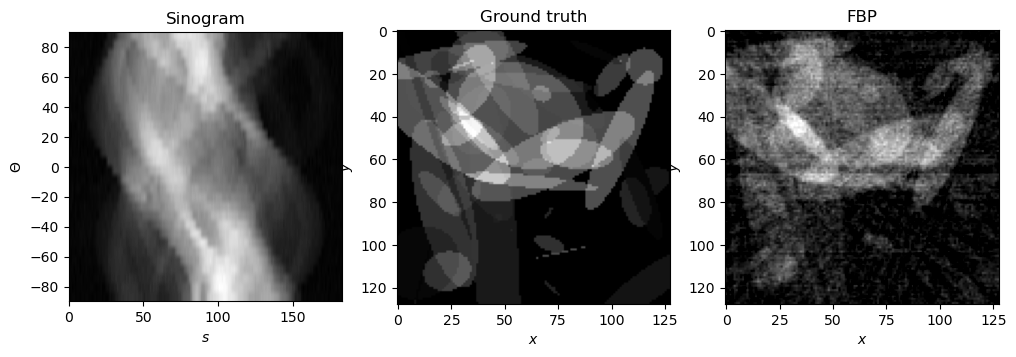

In [5]:
import skimage.transform as sktr

# Get a sample from the generator
sinogram, ground_truth = next(dat_gen)
sinogram = np.asarray(sinogram).transpose()

# This defines the projectiona angles
theta = np.linspace(-90., 90., sinogram.shape[1], endpoint=True)

# Perform FBP
fbp_recon = sktr.iradon(sinogram, theta=theta, filter_name='ramp')[28:-27, 28:-27]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(sinogram.transpose(), cmap='gray', extent=[0, 183, -90, 90])
axs[0].set_title('Sinogram')
axs[0].set_xlabel('$s$')
axs[0].set_ylabel('$\Theta$')
axs[1].imshow(ground_truth, cmap='gray', clim=[0, 1])
axs[1].set_title('Ground truth')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
axs[2].imshow(fbp_recon, cmap='gray', clim=[0, 1])
axs[2].set_title('FBP')
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$y$')
plt.show()

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
   ⌨ <b>Exercise</b>: What do you think of the quality of the reconstructed FBP algorithm? Use the cell below to quantify the similarity between the images using the structural similarity index (SSIM). Does this reflect your intuition? Also compute the PSNR using the <a href="https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.peak_signal_noise_ratio"><code>peak_signal_noise_ratio</code></a> method in scikit-image.
</div>

In [6]:
import skimage.metrics as skme

print('SSIM = {:.2f}'.format(skme.structural_similarity(np.asarray(ground_truth), fbp_recon, data_range=np.max(ground_truth)-np.min(ground_truth))))
print('PSNR = {:.2f}'.format(skme.peak_signal_noise_ratio(np.asarray(ground_truth), fbp_recon)))

SSIM = 0.36
PSNR = 20.68


### Datasets and dataloaders

Our (or your) goal now is to obtain high(er) quality reconstructed images based on the sinogram measurements. As you have seen in the lecture, this can be done in four ways:
1. Train a reconstruction method that directly maps from the measurement (sinogram) domain to the image domain.
2. **Preprocessing** Clean up the sinogram using a neural network, then backproject to the image domain.
3. **Postprocessing** First backproject to the image domain, then improve the reconstruction using a neural network.
4. Iterative methods that integrate data consistency.

Here, we will follow the third approach, postprocessing. We create reconstructions from the generated sinograms using filtered backprojection and use a neural network to learn corrections on this FBP image and improve the reconstruction, as shown in the image below. The data that we need for training this network is the reconstructions from FBP, and the ground-truth reconstructions from the dival dataset. 
<img src='https://imgur.com/df4RYzE.png%27></img>'></img>

We will make a training dataset of 512 samples from the ellipses dival dataset that we store in a MONAI <code>DataSet</code>. The code below does this in four steps:
1. Create a dival generator, that creates sinograms and ground-truth reconstructions.
2. Make a dictionary (like we did in the previous tutorial) that contains the ground-truth reconstructions and the reconstructions constructed by FBP as separate keys.
3. Define the transforms for the data (also like the previous tutorial). In this case we require an additional 'channels' dimension, as that is what the neural network expects. We will not make use of extra data augmentation.
4. Construct the dataset using the dictionary and the defined transform.

In [7]:
import tqdm
import monai

theta = np.linspace(-90., 90., sinogram.shape[1], endpoint=True)

# Make a generator for the training part of the dataset
train_gen = dataset.generator(part='train')
train_samples = []

# Make a list of (in this case) 512 random training samples. We store the filtered backprojection (FBP) and ground truth image
# in a dictionary for each sample, and add these to a list.
for ns in tqdm.tqdm(range(512)):
    sinogram, ground_truth = next(train_gen)
    sinogram = np.asarray(sinogram).transpose()
    fbp_recon = sktr.iradon(sinogram, theta=theta, filter_name='ramp')[28:-27, 28:-27]
    train_samples.append({'fbp': fbp_recon, 'ground_truth': np.asarray(ground_truth)})

# You can add or remove transforms here
train_transform = monai.transforms.Compose([
    monai.transforms.AddChanneld(keys=['fbp', 'ground_truth'])
])    

# Use the list of dictionaries and the transform to initialize a MONAI CacheDataset
train_dataset = monai.data.CacheDataset(train_samples, transform=train_transform)    

  0%|                                                   | 0/512 [00:00<?, ?it/s]

  0%|                                           | 1/512 [00:00<03:15,  2.61it/s]

  0%|▏                                          | 2/512 [00:00<03:14,  2.62it/s]

  1%|▎                                          | 3/512 [00:01<03:14,  2.62it/s]

  1%|▎                                          | 4/512 [00:01<03:19,  2.55it/s]

  1%|▍                                          | 5/512 [00:01<03:17,  2.57it/s]

  1%|▌                                          | 6/512 [00:02<03:15,  2.58it/s]

  1%|▌                                          | 7/512 [00:02<03:14,  2.59it/s]

  2%|▋                                          | 8/512 [00:03<03:13,  2.60it/s]

  2%|▊                                          | 9/512 [00:03<03:12,  2.62it/s]

  2%|▊                                         | 10/512 [00:03<03:11,  2.62it/s]

  2%|▉                                         | 11/512 [00:04<03:11,  2.62it/s]

  2%|▉                                         | 12/512 [00:04<03:11,  2.62it/s]

  3%|█                                         | 13/512 [00:05<03:14,  2.57it/s]

  3%|█▏                                        | 14/512 [00:05<03:12,  2.59it/s]

  3%|█▏                                        | 15/512 [00:05<03:10,  2.61it/s]

  3%|█▎                                        | 16/512 [00:06<03:09,  2.61it/s]

  3%|█▍                                        | 17/512 [00:06<03:08,  2.62it/s]

  4%|█▍                                        | 18/512 [00:06<03:08,  2.63it/s]

  4%|█▌                                        | 19/512 [00:07<03:07,  2.64it/s]

  4%|█▋                                        | 20/512 [00:07<03:06,  2.64it/s]

  4%|█▋                                        | 21/512 [00:08<03:05,  2.64it/s]

  4%|█▊                                        | 22/512 [00:08<03:05,  2.65it/s]

  4%|█▉                                        | 23/512 [00:08<03:04,  2.65it/s]

  5%|█▉                                        | 24/512 [00:09<03:04,  2.65it/s]

  5%|██                                        | 25/512 [00:09<03:04,  2.65it/s]

  5%|██▏                                       | 26/512 [00:09<03:04,  2.64it/s]

  5%|██▏                                       | 27/512 [00:10<03:03,  2.64it/s]

  5%|██▎                                       | 28/512 [00:10<03:03,  2.64it/s]

  6%|██▍                                       | 29/512 [00:11<03:02,  2.65it/s]

  6%|██▍                                       | 30/512 [00:11<03:02,  2.64it/s]

  6%|██▌                                       | 31/512 [00:11<03:02,  2.64it/s]

  6%|██▋                                       | 32/512 [00:12<03:01,  2.64it/s]

  6%|██▋                                       | 33/512 [00:12<03:01,  2.64it/s]

  7%|██▊                                       | 34/512 [00:12<03:00,  2.64it/s]

  7%|██▊                                       | 35/512 [00:13<03:00,  2.64it/s]

  7%|██▉                                       | 36/512 [00:13<03:00,  2.64it/s]

  7%|███                                       | 37/512 [00:14<03:02,  2.60it/s]

  7%|███                                       | 38/512 [00:14<03:02,  2.60it/s]

  8%|███▏                                      | 39/512 [00:14<03:01,  2.61it/s]

  8%|███▎                                      | 40/512 [00:15<03:00,  2.62it/s]

  8%|███▎                                      | 41/512 [00:15<02:59,  2.62it/s]

  8%|███▍                                      | 42/512 [00:16<02:59,  2.62it/s]

  8%|███▌                                      | 43/512 [00:16<02:58,  2.62it/s]

  9%|███▌                                      | 44/512 [00:16<02:58,  2.63it/s]

  9%|███▋                                      | 45/512 [00:17<03:00,  2.58it/s]

  9%|███▊                                      | 46/512 [00:17<02:58,  2.60it/s]

  9%|███▊                                      | 47/512 [00:17<02:57,  2.62it/s]

  9%|███▉                                      | 48/512 [00:18<02:56,  2.62it/s]

 10%|████                                      | 49/512 [00:18<02:55,  2.63it/s]

 10%|████                                      | 50/512 [00:19<02:55,  2.64it/s]

 10%|████▏                                     | 51/512 [00:19<02:55,  2.63it/s]

 10%|████▎                                     | 52/512 [00:19<02:55,  2.63it/s]

 10%|████▎                                     | 53/512 [00:20<02:54,  2.62it/s]

 11%|████▍                                     | 54/512 [00:20<02:53,  2.63it/s]

 11%|████▌                                     | 55/512 [00:20<02:53,  2.64it/s]

 11%|████▌                                     | 56/512 [00:21<02:52,  2.64it/s]

 11%|████▋                                     | 57/512 [00:21<02:52,  2.63it/s]

 11%|████▊                                     | 58/512 [00:22<02:52,  2.63it/s]

 12%|████▊                                     | 59/512 [00:22<02:52,  2.63it/s]

 12%|████▉                                     | 60/512 [00:22<02:51,  2.63it/s]

 12%|█████                                     | 61/512 [00:23<02:50,  2.64it/s]

 12%|█████                                     | 62/512 [00:23<02:50,  2.64it/s]

 12%|█████▏                                    | 63/512 [00:24<02:49,  2.65it/s]

 12%|█████▎                                    | 64/512 [00:24<02:49,  2.65it/s]

 13%|█████▎                                    | 65/512 [00:24<02:49,  2.64it/s]

 13%|█████▍                                    | 66/512 [00:25<02:49,  2.63it/s]

 13%|█████▍                                    | 67/512 [00:25<02:48,  2.64it/s]

 13%|█████▌                                    | 68/512 [00:25<02:48,  2.64it/s]

 13%|█████▋                                    | 69/512 [00:26<02:47,  2.64it/s]

 14%|█████▋                                    | 70/512 [00:26<02:47,  2.64it/s]

 14%|█████▊                                    | 71/512 [00:27<02:47,  2.64it/s]

 14%|█████▉                                    | 72/512 [00:27<02:46,  2.64it/s]

 14%|█████▉                                    | 73/512 [00:27<02:46,  2.64it/s]

 14%|██████                                    | 74/512 [00:28<02:46,  2.63it/s]

 15%|██████▏                                   | 75/512 [00:28<02:46,  2.63it/s]

 15%|██████▏                                   | 76/512 [00:28<02:45,  2.64it/s]

 15%|██████▎                                   | 77/512 [00:29<02:45,  2.63it/s]

 15%|██████▍                                   | 78/512 [00:29<02:44,  2.64it/s]

 15%|██████▍                                   | 79/512 [00:30<02:44,  2.64it/s]

 16%|██████▌                                   | 80/512 [00:30<02:43,  2.64it/s]

 16%|██████▋                                   | 81/512 [00:30<02:42,  2.65it/s]

 16%|██████▋                                   | 82/512 [00:31<02:42,  2.64it/s]

 16%|██████▊                                   | 83/512 [00:31<02:42,  2.64it/s]

 16%|██████▉                                   | 84/512 [00:31<02:41,  2.65it/s]

 17%|██████▉                                   | 85/512 [00:32<02:41,  2.64it/s]

 17%|███████                                   | 86/512 [00:32<02:41,  2.64it/s]

 17%|███████▏                                  | 87/512 [00:33<02:40,  2.65it/s]

 17%|███████▏                                  | 88/512 [00:33<02:40,  2.64it/s]

 17%|███████▎                                  | 89/512 [00:33<02:39,  2.65it/s]

 18%|███████▍                                  | 90/512 [00:34<02:39,  2.64it/s]

 18%|███████▍                                  | 91/512 [00:34<02:39,  2.64it/s]

 18%|███████▌                                  | 92/512 [00:34<02:39,  2.64it/s]

 18%|███████▋                                  | 93/512 [00:35<02:39,  2.63it/s]

 18%|███████▋                                  | 94/512 [00:35<02:38,  2.63it/s]

 19%|███████▊                                  | 95/512 [00:36<02:37,  2.64it/s]

 19%|███████▉                                  | 96/512 [00:36<02:37,  2.64it/s]

 19%|███████▉                                  | 97/512 [00:36<02:36,  2.64it/s]

 19%|████████                                  | 98/512 [00:37<02:38,  2.61it/s]

 19%|████████                                  | 99/512 [00:37<02:37,  2.62it/s]

 20%|████████                                 | 100/512 [00:38<02:36,  2.64it/s]

 20%|████████                                 | 101/512 [00:38<02:35,  2.64it/s]

 20%|████████▏                                | 102/512 [00:38<02:35,  2.64it/s]

 20%|████████▏                                | 103/512 [00:39<02:34,  2.64it/s]

 20%|████████▎                                | 104/512 [00:39<02:34,  2.64it/s]

 21%|████████▍                                | 105/512 [00:39<02:34,  2.64it/s]

 21%|████████▍                                | 106/512 [00:40<02:33,  2.65it/s]

 21%|████████▌                                | 107/512 [00:40<02:33,  2.64it/s]

 21%|████████▋                                | 108/512 [00:41<02:33,  2.64it/s]

 21%|████████▋                                | 109/512 [00:41<02:33,  2.63it/s]

 21%|████████▊                                | 110/512 [00:41<02:32,  2.64it/s]

 22%|████████▉                                | 111/512 [00:42<02:31,  2.64it/s]

 22%|████████▉                                | 112/512 [00:42<02:31,  2.64it/s]

 22%|█████████                                | 113/512 [00:42<02:31,  2.64it/s]

 22%|█████████▏                               | 114/512 [00:43<02:30,  2.64it/s]

 22%|█████████▏                               | 115/512 [00:43<02:30,  2.64it/s]

 23%|█████████▎                               | 116/512 [00:44<02:30,  2.64it/s]

 23%|█████████▎                               | 117/512 [00:44<02:29,  2.64it/s]

 23%|█████████▍                               | 118/512 [00:44<02:29,  2.64it/s]

 23%|█████████▌                               | 119/512 [00:45<02:29,  2.64it/s]

 23%|█████████▌                               | 120/512 [00:45<02:28,  2.64it/s]

 24%|█████████▋                               | 121/512 [00:45<02:27,  2.64it/s]

 24%|█████████▊                               | 122/512 [00:46<02:27,  2.65it/s]

 24%|█████████▊                               | 123/512 [00:46<02:26,  2.65it/s]

 24%|█████████▉                               | 124/512 [00:47<02:26,  2.65it/s]

 24%|██████████                               | 125/512 [00:47<02:28,  2.61it/s]

 25%|██████████                               | 126/512 [00:47<02:27,  2.62it/s]

 25%|██████████▏                              | 127/512 [00:48<02:26,  2.63it/s]

 25%|██████████▎                              | 128/512 [00:48<02:25,  2.64it/s]

 25%|██████████▎                              | 129/512 [00:49<02:25,  2.64it/s]

 25%|██████████▍                              | 130/512 [00:49<02:25,  2.63it/s]

 26%|██████████▍                              | 131/512 [00:49<02:25,  2.63it/s]

 26%|██████████▌                              | 132/512 [00:50<02:24,  2.62it/s]

 26%|██████████▋                              | 133/512 [00:50<02:24,  2.62it/s]

 26%|██████████▋                              | 134/512 [00:50<02:24,  2.62it/s]

 26%|██████████▊                              | 135/512 [00:51<02:23,  2.62it/s]

 27%|██████████▉                              | 136/512 [00:51<02:22,  2.63it/s]

 27%|██████████▉                              | 137/512 [00:52<02:22,  2.64it/s]

 27%|███████████                              | 138/512 [00:52<02:21,  2.64it/s]

 27%|███████████▏                             | 139/512 [00:52<02:21,  2.64it/s]

 27%|███████████▏                             | 140/512 [00:53<02:22,  2.61it/s]

 28%|███████████▎                             | 141/512 [00:53<02:21,  2.62it/s]

 28%|███████████▎                             | 142/512 [00:53<02:21,  2.62it/s]

 28%|███████████▍                             | 143/512 [00:54<02:20,  2.63it/s]

 28%|███████████▌                             | 144/512 [00:54<02:19,  2.63it/s]

 28%|███████████▌                             | 145/512 [00:55<02:19,  2.63it/s]

 29%|███████████▋                             | 146/512 [00:55<02:18,  2.64it/s]

 29%|███████████▊                             | 147/512 [00:55<02:18,  2.63it/s]

 29%|███████████▊                             | 148/512 [00:56<02:18,  2.63it/s]

 29%|███████████▉                             | 149/512 [00:56<02:17,  2.64it/s]

 29%|████████████                             | 150/512 [00:57<02:17,  2.64it/s]

 29%|████████████                             | 151/512 [00:57<02:16,  2.64it/s]

 30%|████████████▏                            | 152/512 [00:57<02:16,  2.64it/s]

 30%|████████████▎                            | 153/512 [00:58<02:15,  2.64it/s]

 30%|████████████▎                            | 154/512 [00:58<02:15,  2.64it/s]

 30%|████████████▍                            | 155/512 [00:58<02:15,  2.64it/s]

 30%|████████████▍                            | 156/512 [00:59<02:14,  2.64it/s]

 31%|████████████▌                            | 157/512 [00:59<02:14,  2.64it/s]

 31%|████████████▋                            | 158/512 [01:00<02:13,  2.65it/s]

 31%|████████████▋                            | 159/512 [01:00<02:13,  2.64it/s]

 31%|████████████▊                            | 160/512 [01:00<02:13,  2.63it/s]

 31%|████████████▉                            | 161/512 [01:01<02:13,  2.63it/s]

 32%|████████████▉                            | 162/512 [01:01<02:12,  2.64it/s]

 32%|█████████████                            | 163/512 [01:01<02:12,  2.64it/s]

 32%|█████████████▏                           | 164/512 [01:02<02:11,  2.64it/s]

 32%|█████████████▏                           | 165/512 [01:02<02:12,  2.62it/s]

 32%|█████████████▎                           | 166/512 [01:03<02:11,  2.63it/s]

 33%|█████████████▎                           | 167/512 [01:03<02:11,  2.63it/s]

 33%|█████████████▍                           | 168/512 [01:03<02:10,  2.63it/s]

 33%|█████████████▌                           | 169/512 [01:04<02:10,  2.63it/s]

 33%|█████████████▌                           | 170/512 [01:04<02:09,  2.63it/s]

 33%|█████████████▋                           | 171/512 [01:04<02:09,  2.64it/s]

 34%|█████████████▊                           | 172/512 [01:05<02:09,  2.63it/s]

 34%|█████████████▊                           | 173/512 [01:05<02:10,  2.60it/s]

 34%|█████████████▉                           | 174/512 [01:06<02:09,  2.61it/s]

 34%|██████████████                           | 175/512 [01:06<02:08,  2.62it/s]

 34%|██████████████                           | 176/512 [01:06<02:08,  2.62it/s]

 35%|██████████████▏                          | 177/512 [01:07<02:09,  2.59it/s]

 35%|██████████████▎                          | 178/512 [01:07<02:08,  2.61it/s]

 35%|██████████████▎                          | 179/512 [01:08<02:07,  2.61it/s]

 35%|██████████████▍                          | 180/512 [01:08<02:06,  2.62it/s]

 35%|██████████████▍                          | 181/512 [01:08<02:07,  2.59it/s]

 36%|██████████████▌                          | 182/512 [01:09<02:07,  2.58it/s]

 36%|██████████████▋                          | 183/512 [01:09<02:06,  2.59it/s]

 36%|██████████████▋                          | 184/512 [01:09<02:05,  2.62it/s]

 36%|██████████████▊                          | 185/512 [01:10<02:04,  2.63it/s]

 36%|██████████████▉                          | 186/512 [01:10<02:04,  2.63it/s]

 37%|██████████████▉                          | 187/512 [01:11<02:03,  2.63it/s]

 37%|███████████████                          | 188/512 [01:11<02:03,  2.63it/s]

 37%|███████████████▏                         | 189/512 [01:11<02:02,  2.64it/s]

 37%|███████████████▏                         | 190/512 [01:12<02:02,  2.64it/s]

 37%|███████████████▎                         | 191/512 [01:12<02:04,  2.59it/s]

 38%|███████████████▍                         | 192/512 [01:13<02:03,  2.60it/s]

 38%|███████████████▍                         | 193/512 [01:13<02:02,  2.61it/s]

 38%|███████████████▌                         | 194/512 [01:13<02:01,  2.62it/s]

 38%|███████████████▌                         | 195/512 [01:14<02:00,  2.63it/s]

 38%|███████████████▋                         | 196/512 [01:14<01:59,  2.64it/s]

 38%|███████████████▊                         | 197/512 [01:14<01:59,  2.65it/s]

 39%|███████████████▊                         | 198/512 [01:15<01:58,  2.65it/s]

 39%|███████████████▉                         | 199/512 [01:15<02:00,  2.59it/s]

 39%|████████████████                         | 200/512 [01:16<01:59,  2.61it/s]

 39%|████████████████                         | 201/512 [01:16<01:59,  2.61it/s]

 39%|████████████████▏                        | 202/512 [01:16<01:58,  2.61it/s]

 40%|████████████████▎                        | 203/512 [01:17<01:58,  2.61it/s]

 40%|████████████████▎                        | 204/512 [01:17<01:57,  2.62it/s]

 40%|████████████████▍                        | 205/512 [01:17<01:57,  2.62it/s]

 40%|████████████████▍                        | 206/512 [01:18<01:56,  2.63it/s]

 40%|████████████████▌                        | 207/512 [01:18<01:55,  2.64it/s]

 41%|████████████████▋                        | 208/512 [01:19<01:55,  2.63it/s]

 41%|████████████████▋                        | 209/512 [01:19<01:54,  2.64it/s]

 41%|████████████████▊                        | 210/512 [01:19<01:54,  2.64it/s]

 41%|████████████████▉                        | 211/512 [01:20<01:53,  2.64it/s]

 41%|████████████████▉                        | 212/512 [01:20<01:53,  2.64it/s]

 42%|█████████████████                        | 213/512 [01:21<01:53,  2.64it/s]

 42%|█████████████████▏                       | 214/512 [01:21<01:52,  2.64it/s]

 42%|█████████████████▏                       | 215/512 [01:21<01:52,  2.65it/s]

 42%|█████████████████▎                       | 216/512 [01:22<01:51,  2.65it/s]

 42%|█████████████████▍                       | 217/512 [01:22<01:51,  2.65it/s]

 43%|█████████████████▍                       | 218/512 [01:22<01:50,  2.65it/s]

 43%|█████████████████▌                       | 219/512 [01:23<01:50,  2.65it/s]

 43%|█████████████████▌                       | 220/512 [01:23<01:50,  2.65it/s]

 43%|█████████████████▋                       | 221/512 [01:24<01:50,  2.64it/s]

 43%|█████████████████▊                       | 222/512 [01:24<01:50,  2.61it/s]

 44%|█████████████████▊                       | 223/512 [01:24<01:50,  2.62it/s]

 44%|█████████████████▉                       | 224/512 [01:25<01:49,  2.63it/s]

 44%|██████████████████                       | 225/512 [01:25<01:48,  2.64it/s]

 44%|██████████████████                       | 226/512 [01:25<01:48,  2.64it/s]

 44%|██████████████████▏                      | 227/512 [01:26<01:47,  2.64it/s]

 45%|██████████████████▎                      | 228/512 [01:26<01:47,  2.64it/s]

 45%|██████████████████▎                      | 229/512 [01:27<01:47,  2.64it/s]

 45%|██████████████████▍                      | 230/512 [01:27<01:47,  2.63it/s]

 45%|██████████████████▍                      | 231/512 [01:27<01:46,  2.63it/s]

 45%|██████████████████▌                      | 232/512 [01:28<01:46,  2.64it/s]

 46%|██████████████████▋                      | 233/512 [01:28<01:50,  2.53it/s]

 46%|██████████████████▋                      | 234/512 [01:29<01:48,  2.56it/s]

 46%|██████████████████▊                      | 235/512 [01:29<01:47,  2.59it/s]

 46%|██████████████████▉                      | 236/512 [01:29<01:45,  2.61it/s]

 46%|██████████████████▉                      | 237/512 [01:30<01:45,  2.61it/s]

 46%|███████████████████                      | 238/512 [01:30<01:44,  2.62it/s]

 47%|███████████████████▏                     | 239/512 [01:30<01:43,  2.63it/s]

 47%|███████████████████▏                     | 240/512 [01:31<01:43,  2.63it/s]

 47%|███████████████████▎                     | 241/512 [01:31<01:42,  2.64it/s]

 47%|███████████████████▍                     | 242/512 [01:32<01:42,  2.64it/s]

 47%|███████████████████▍                     | 243/512 [01:32<01:41,  2.64it/s]

 48%|███████████████████▌                     | 244/512 [01:32<01:41,  2.64it/s]

 48%|███████████████████▌                     | 245/512 [01:33<01:41,  2.64it/s]

 48%|███████████████████▋                     | 246/512 [01:33<01:40,  2.65it/s]

 48%|███████████████████▊                     | 247/512 [01:33<01:40,  2.65it/s]

 48%|███████████████████▊                     | 248/512 [01:34<01:39,  2.64it/s]

 49%|███████████████████▉                     | 249/512 [01:34<01:39,  2.64it/s]

 49%|████████████████████                     | 250/512 [01:35<01:39,  2.64it/s]

 49%|████████████████████                     | 251/512 [01:35<01:38,  2.64it/s]

 49%|████████████████████▏                    | 252/512 [01:35<01:38,  2.64it/s]

 49%|████████████████████▎                    | 253/512 [01:36<01:38,  2.64it/s]

 50%|████████████████████▎                    | 254/512 [01:36<01:37,  2.63it/s]

 50%|████████████████████▍                    | 255/512 [01:36<01:37,  2.64it/s]

 50%|████████████████████▌                    | 256/512 [01:37<01:37,  2.64it/s]

 50%|████████████████████▌                    | 257/512 [01:37<01:36,  2.63it/s]

 50%|████████████████████▋                    | 258/512 [01:38<01:36,  2.64it/s]

 51%|████████████████████▋                    | 259/512 [01:38<01:37,  2.61it/s]

 51%|████████████████████▊                    | 260/512 [01:38<01:36,  2.61it/s]

 51%|████████████████████▉                    | 261/512 [01:39<01:36,  2.61it/s]

 51%|████████████████████▉                    | 262/512 [01:39<01:35,  2.62it/s]

 51%|█████████████████████                    | 263/512 [01:40<01:34,  2.63it/s]

 52%|█████████████████████▏                   | 264/512 [01:40<01:34,  2.63it/s]

 52%|█████████████████████▏                   | 265/512 [01:40<01:33,  2.64it/s]

 52%|█████████████████████▎                   | 266/512 [01:41<01:33,  2.64it/s]

 52%|█████████████████████▍                   | 267/512 [01:41<01:32,  2.64it/s]

 52%|█████████████████████▍                   | 268/512 [01:41<01:32,  2.64it/s]

 53%|█████████████████████▌                   | 269/512 [01:42<01:32,  2.64it/s]

 53%|█████████████████████▌                   | 270/512 [01:42<01:31,  2.64it/s]

 53%|█████████████████████▋                   | 271/512 [01:43<01:31,  2.64it/s]

 53%|█████████████████████▊                   | 272/512 [01:43<01:31,  2.64it/s]

 53%|█████████████████████▊                   | 273/512 [01:43<01:30,  2.64it/s]

 54%|█████████████████████▉                   | 274/512 [01:44<01:30,  2.64it/s]

 54%|██████████████████████                   | 275/512 [01:44<01:29,  2.65it/s]

 54%|██████████████████████                   | 276/512 [01:44<01:29,  2.65it/s]

 54%|██████████████████████▏                  | 277/512 [01:45<01:28,  2.64it/s]

 54%|██████████████████████▎                  | 278/512 [01:45<01:28,  2.65it/s]

 54%|██████████████████████▎                  | 279/512 [01:46<01:28,  2.62it/s]

 55%|██████████████████████▍                  | 280/512 [01:46<01:28,  2.63it/s]

 55%|██████████████████████▌                  | 281/512 [01:46<01:27,  2.63it/s]

 55%|██████████████████████▌                  | 282/512 [01:47<01:27,  2.64it/s]

 55%|██████████████████████▋                  | 283/512 [01:47<01:26,  2.64it/s]

 55%|██████████████████████▋                  | 284/512 [01:47<01:26,  2.64it/s]

 56%|██████████████████████▊                  | 285/512 [01:48<01:25,  2.64it/s]

 56%|██████████████████████▉                  | 286/512 [01:48<01:25,  2.64it/s]

 56%|██████████████████████▉                  | 287/512 [01:49<01:26,  2.60it/s]

 56%|███████████████████████                  | 288/512 [01:49<01:26,  2.60it/s]

 56%|███████████████████████▏                 | 289/512 [01:49<01:25,  2.62it/s]

 57%|███████████████████████▏                 | 290/512 [01:50<01:24,  2.62it/s]

 57%|███████████████████████▎                 | 291/512 [01:50<01:24,  2.63it/s]

 57%|███████████████████████▍                 | 292/512 [01:51<01:23,  2.63it/s]

 57%|███████████████████████▍                 | 293/512 [01:51<01:22,  2.64it/s]

 57%|███████████████████████▌                 | 294/512 [01:51<01:22,  2.64it/s]

 58%|███████████████████████▌                 | 295/512 [01:52<01:22,  2.64it/s]

 58%|███████████████████████▋                 | 296/512 [01:52<01:21,  2.64it/s]

 58%|███████████████████████▊                 | 297/512 [01:52<01:21,  2.65it/s]

 58%|███████████████████████▊                 | 298/512 [01:53<01:22,  2.61it/s]

 58%|███████████████████████▉                 | 299/512 [01:53<01:21,  2.62it/s]

 59%|████████████████████████                 | 300/512 [01:54<01:20,  2.62it/s]

 59%|████████████████████████                 | 301/512 [01:54<01:20,  2.63it/s]

 59%|████████████████████████▏                | 302/512 [01:54<01:19,  2.64it/s]

 59%|████████████████████████▎                | 303/512 [01:55<01:19,  2.64it/s]

 59%|████████████████████████▎                | 304/512 [01:55<01:19,  2.61it/s]

 60%|████████████████████████▍                | 305/512 [01:55<01:19,  2.61it/s]

 60%|████████████████████████▌                | 306/512 [01:56<01:18,  2.62it/s]

 60%|████████████████████████▌                | 307/512 [01:56<01:17,  2.63it/s]

 60%|████████████████████████▋                | 308/512 [01:57<01:17,  2.64it/s]

 60%|████████████████████████▋                | 309/512 [01:57<01:16,  2.64it/s]

 61%|████████████████████████▊                | 310/512 [01:57<01:16,  2.64it/s]

 61%|████████████████████████▉                | 311/512 [01:58<01:16,  2.64it/s]

 61%|████████████████████████▉                | 312/512 [01:58<01:15,  2.64it/s]

 61%|█████████████████████████                | 313/512 [01:59<01:15,  2.63it/s]

 61%|█████████████████████████▏               | 314/512 [01:59<01:15,  2.63it/s]

 62%|█████████████████████████▏               | 315/512 [01:59<01:14,  2.64it/s]

 62%|█████████████████████████▎               | 316/512 [02:00<01:14,  2.65it/s]

 62%|█████████████████████████▍               | 317/512 [02:00<01:13,  2.65it/s]

 62%|█████████████████████████▍               | 318/512 [02:00<01:13,  2.64it/s]

 62%|█████████████████████████▌               | 319/512 [02:01<01:13,  2.64it/s]

 62%|█████████████████████████▋               | 320/512 [02:01<01:12,  2.64it/s]

 63%|█████████████████████████▋               | 321/512 [02:02<01:12,  2.64it/s]

 63%|█████████████████████████▊               | 322/512 [02:02<01:11,  2.64it/s]

 63%|█████████████████████████▊               | 323/512 [02:02<01:11,  2.64it/s]

 63%|█████████████████████████▉               | 324/512 [02:03<01:11,  2.65it/s]

 63%|██████████████████████████               | 325/512 [02:03<01:10,  2.65it/s]

 64%|██████████████████████████               | 326/512 [02:03<01:10,  2.65it/s]

 64%|██████████████████████████▏              | 327/512 [02:04<01:09,  2.65it/s]

 64%|██████████████████████████▎              | 328/512 [02:04<01:09,  2.64it/s]

 64%|██████████████████████████▎              | 329/512 [02:05<01:09,  2.64it/s]

 64%|██████████████████████████▍              | 330/512 [02:05<01:08,  2.64it/s]

 65%|██████████████████████████▌              | 331/512 [02:05<01:08,  2.64it/s]

 65%|██████████████████████████▌              | 332/512 [02:06<01:08,  2.64it/s]

 65%|██████████████████████████▋              | 333/512 [02:06<01:07,  2.63it/s]

 65%|██████████████████████████▋              | 334/512 [02:06<01:07,  2.64it/s]

 65%|██████████████████████████▊              | 335/512 [02:07<01:07,  2.64it/s]

 66%|██████████████████████████▉              | 336/512 [02:07<01:06,  2.64it/s]

 66%|██████████████████████████▉              | 337/512 [02:08<01:07,  2.60it/s]

 66%|███████████████████████████              | 338/512 [02:08<01:06,  2.62it/s]

 66%|███████████████████████████▏             | 339/512 [02:08<01:05,  2.62it/s]

 66%|███████████████████████████▏             | 340/512 [02:09<01:05,  2.63it/s]

 67%|███████████████████████████▎             | 341/512 [02:09<01:05,  2.61it/s]

 67%|███████████████████████████▍             | 342/512 [02:10<01:05,  2.61it/s]

 67%|███████████████████████████▍             | 343/512 [02:10<01:04,  2.62it/s]

 67%|███████████████████████████▌             | 344/512 [02:10<01:03,  2.63it/s]

 67%|███████████████████████████▋             | 345/512 [02:11<01:03,  2.63it/s]

 68%|███████████████████████████▋             | 346/512 [02:11<01:03,  2.63it/s]

 68%|███████████████████████████▊             | 347/512 [02:11<01:02,  2.63it/s]

 68%|███████████████████████████▊             | 348/512 [02:12<01:02,  2.64it/s]

 68%|███████████████████████████▉             | 349/512 [02:12<01:01,  2.63it/s]

 68%|████████████████████████████             | 350/512 [02:13<01:01,  2.64it/s]

 69%|████████████████████████████             | 351/512 [02:13<01:01,  2.64it/s]

 69%|████████████████████████████▏            | 352/512 [02:13<01:00,  2.64it/s]

 69%|████████████████████████████▎            | 353/512 [02:14<00:59,  2.65it/s]

 69%|████████████████████████████▎            | 354/512 [02:14<00:59,  2.65it/s]

 69%|████████████████████████████▍            | 355/512 [02:14<00:59,  2.64it/s]

 70%|████████████████████████████▌            | 356/512 [02:15<00:59,  2.64it/s]

 70%|████████████████████████████▌            | 357/512 [02:15<00:58,  2.65it/s]

 70%|████████████████████████████▋            | 358/512 [02:16<00:58,  2.64it/s]

 70%|████████████████████████████▋            | 359/512 [02:16<00:57,  2.64it/s]

 70%|████████████████████████████▊            | 360/512 [02:16<00:57,  2.65it/s]

 71%|████████████████████████████▉            | 361/512 [02:17<00:57,  2.65it/s]

 71%|████████████████████████████▉            | 362/512 [02:17<00:56,  2.65it/s]

 71%|█████████████████████████████            | 363/512 [02:17<00:56,  2.65it/s]

 71%|█████████████████████████████▏           | 364/512 [02:18<00:55,  2.64it/s]

 71%|█████████████████████████████▏           | 365/512 [02:18<00:55,  2.64it/s]

 71%|█████████████████████████████▎           | 366/512 [02:19<00:55,  2.65it/s]

 72%|█████████████████████████████▍           | 367/512 [02:19<00:54,  2.64it/s]

 72%|█████████████████████████████▍           | 368/512 [02:19<00:55,  2.59it/s]

 72%|█████████████████████████████▌           | 369/512 [02:20<00:54,  2.60it/s]

 72%|█████████████████████████████▋           | 370/512 [02:20<00:54,  2.61it/s]

 72%|█████████████████████████████▋           | 371/512 [02:21<00:53,  2.63it/s]

 73%|█████████████████████████████▊           | 372/512 [02:21<00:53,  2.63it/s]

 73%|█████████████████████████████▊           | 373/512 [02:21<00:52,  2.63it/s]

 73%|█████████████████████████████▉           | 374/512 [02:22<00:52,  2.64it/s]

 73%|██████████████████████████████           | 375/512 [02:22<00:52,  2.60it/s]

 73%|██████████████████████████████           | 376/512 [02:22<00:52,  2.61it/s]

 74%|██████████████████████████████▏          | 377/512 [02:23<00:51,  2.62it/s]

 74%|██████████████████████████████▎          | 378/512 [02:23<00:51,  2.62it/s]

 74%|██████████████████████████████▎          | 379/512 [02:24<00:50,  2.63it/s]

 74%|██████████████████████████████▍          | 380/512 [02:24<00:50,  2.64it/s]

 74%|██████████████████████████████▌          | 381/512 [02:24<00:49,  2.64it/s]

 75%|██████████████████████████████▌          | 382/512 [02:25<00:49,  2.61it/s]

 75%|██████████████████████████████▋          | 383/512 [02:25<00:49,  2.62it/s]

 75%|██████████████████████████████▊          | 384/512 [02:25<00:48,  2.63it/s]

 75%|██████████████████████████████▊          | 385/512 [02:26<00:48,  2.63it/s]

 75%|██████████████████████████████▉          | 386/512 [02:26<00:47,  2.63it/s]

 76%|██████████████████████████████▉          | 387/512 [02:27<00:47,  2.63it/s]

 76%|███████████████████████████████          | 388/512 [02:27<00:47,  2.63it/s]

 76%|███████████████████████████████▏         | 389/512 [02:27<00:46,  2.63it/s]

 76%|███████████████████████████████▏         | 390/512 [02:28<00:46,  2.64it/s]

 76%|███████████████████████████████▎         | 391/512 [02:28<00:45,  2.64it/s]

 77%|███████████████████████████████▍         | 392/512 [02:29<00:45,  2.63it/s]

 77%|███████████████████████████████▍         | 393/512 [02:29<00:45,  2.60it/s]

 77%|███████████████████████████████▌         | 394/512 [02:29<00:45,  2.61it/s]

 77%|███████████████████████████████▋         | 395/512 [02:30<00:44,  2.62it/s]

 77%|███████████████████████████████▋         | 396/512 [02:30<00:44,  2.63it/s]

 78%|███████████████████████████████▊         | 397/512 [02:30<00:43,  2.63it/s]

 78%|███████████████████████████████▊         | 398/512 [02:31<00:43,  2.63it/s]

 78%|███████████████████████████████▉         | 399/512 [02:31<00:42,  2.64it/s]

 78%|████████████████████████████████         | 400/512 [02:32<00:42,  2.64it/s]

 78%|████████████████████████████████         | 401/512 [02:32<00:42,  2.62it/s]

 79%|████████████████████████████████▏        | 402/512 [02:32<00:41,  2.63it/s]

 79%|████████████████████████████████▎        | 403/512 [02:33<00:41,  2.63it/s]

 79%|████████████████████████████████▎        | 404/512 [02:33<00:43,  2.49it/s]

 79%|████████████████████████████████▍        | 405/512 [02:34<00:42,  2.53it/s]

 79%|████████████████████████████████▌        | 406/512 [02:34<00:41,  2.56it/s]

 79%|████████████████████████████████▌        | 407/512 [02:34<00:40,  2.58it/s]

 80%|████████████████████████████████▋        | 408/512 [02:35<00:40,  2.60it/s]

 80%|████████████████████████████████▊        | 409/512 [02:35<00:39,  2.62it/s]

 80%|████████████████████████████████▊        | 410/512 [02:35<00:38,  2.62it/s]

 80%|████████████████████████████████▉        | 411/512 [02:36<00:39,  2.59it/s]

 80%|████████████████████████████████▉        | 412/512 [02:36<00:38,  2.61it/s]

 81%|█████████████████████████████████        | 413/512 [02:37<00:37,  2.62it/s]

 81%|█████████████████████████████████▏       | 414/512 [02:37<00:37,  2.63it/s]

 81%|█████████████████████████████████▏       | 415/512 [02:37<00:36,  2.63it/s]

 81%|█████████████████████████████████▎       | 416/512 [02:38<00:36,  2.63it/s]

 81%|█████████████████████████████████▍       | 417/512 [02:38<00:36,  2.63it/s]

 82%|█████████████████████████████████▍       | 418/512 [02:38<00:35,  2.63it/s]

 82%|█████████████████████████████████▌       | 419/512 [02:39<00:35,  2.63it/s]

 82%|█████████████████████████████████▋       | 420/512 [02:39<00:34,  2.63it/s]

 82%|█████████████████████████████████▋       | 421/512 [02:40<00:34,  2.63it/s]

 82%|█████████████████████████████████▊       | 422/512 [02:40<00:34,  2.62it/s]

 83%|█████████████████████████████████▊       | 423/512 [02:40<00:33,  2.63it/s]

 83%|█████████████████████████████████▉       | 424/512 [02:41<00:33,  2.63it/s]

 83%|██████████████████████████████████       | 425/512 [02:41<00:33,  2.63it/s]

 83%|██████████████████████████████████       | 426/512 [02:42<00:32,  2.63it/s]

 83%|██████████████████████████████████▏      | 427/512 [02:42<00:32,  2.63it/s]

 84%|██████████████████████████████████▎      | 428/512 [02:42<00:31,  2.63it/s]

 84%|██████████████████████████████████▎      | 429/512 [02:43<00:31,  2.63it/s]

 84%|██████████████████████████████████▍      | 430/512 [02:43<00:31,  2.63it/s]

 84%|██████████████████████████████████▌      | 431/512 [02:43<00:30,  2.62it/s]

 84%|██████████████████████████████████▌      | 432/512 [02:44<00:30,  2.63it/s]

 85%|██████████████████████████████████▋      | 433/512 [02:44<00:29,  2.64it/s]

 85%|██████████████████████████████████▊      | 434/512 [02:45<00:29,  2.61it/s]

 85%|██████████████████████████████████▊      | 435/512 [02:45<00:29,  2.61it/s]

 85%|██████████████████████████████████▉      | 436/512 [02:45<00:28,  2.62it/s]

 85%|██████████████████████████████████▉      | 437/512 [02:46<00:28,  2.63it/s]

 86%|███████████████████████████████████      | 438/512 [02:46<00:28,  2.63it/s]

 86%|███████████████████████████████████▏     | 439/512 [02:46<00:27,  2.64it/s]

 86%|███████████████████████████████████▏     | 440/512 [02:47<00:27,  2.65it/s]

 86%|███████████████████████████████████▎     | 441/512 [02:47<00:26,  2.65it/s]

 86%|███████████████████████████████████▍     | 442/512 [02:48<00:26,  2.65it/s]

 87%|███████████████████████████████████▍     | 443/512 [02:48<00:26,  2.65it/s]

 87%|███████████████████████████████████▌     | 444/512 [02:48<00:27,  2.46it/s]

 87%|███████████████████████████████████▋     | 445/512 [02:49<00:27,  2.48it/s]

 87%|███████████████████████████████████▋     | 446/512 [02:49<00:26,  2.53it/s]

 87%|███████████████████████████████████▊     | 447/512 [02:50<00:25,  2.57it/s]

 88%|███████████████████████████████████▉     | 448/512 [02:50<00:24,  2.59it/s]

 88%|███████████████████████████████████▉     | 449/512 [02:50<00:24,  2.60it/s]

 88%|████████████████████████████████████     | 450/512 [02:51<00:23,  2.62it/s]

 88%|████████████████████████████████████     | 451/512 [02:51<00:23,  2.62it/s]

 88%|████████████████████████████████████▏    | 452/512 [02:52<00:23,  2.58it/s]

 88%|████████████████████████████████████▎    | 453/512 [02:52<00:22,  2.61it/s]

 89%|████████████████████████████████████▎    | 454/512 [02:52<00:22,  2.62it/s]

 89%|████████████████████████████████████▍    | 455/512 [02:53<00:21,  2.62it/s]

 89%|████████████████████████████████████▌    | 456/512 [02:53<00:21,  2.63it/s]

 89%|████████████████████████████████████▌    | 457/512 [02:53<00:20,  2.64it/s]

 89%|████████████████████████████████████▋    | 458/512 [02:54<00:20,  2.64it/s]

 90%|████████████████████████████████████▊    | 459/512 [02:54<00:20,  2.65it/s]

 90%|████████████████████████████████████▊    | 460/512 [02:55<00:19,  2.65it/s]

 90%|████████████████████████████████████▉    | 461/512 [02:55<00:19,  2.61it/s]

 90%|████████████████████████████████████▉    | 462/512 [02:55<00:19,  2.61it/s]

 90%|█████████████████████████████████████    | 463/512 [02:56<00:18,  2.62it/s]

 91%|█████████████████████████████████████▏   | 464/512 [02:56<00:18,  2.62it/s]

 91%|█████████████████████████████████████▏   | 465/512 [02:56<00:17,  2.62it/s]

 91%|█████████████████████████████████████▎   | 466/512 [02:57<00:17,  2.63it/s]

 91%|█████████████████████████████████████▍   | 467/512 [02:57<00:17,  2.63it/s]

 91%|█████████████████████████████████████▍   | 468/512 [02:58<00:16,  2.60it/s]

 92%|█████████████████████████████████████▌   | 469/512 [02:58<00:16,  2.61it/s]

 92%|█████████████████████████████████████▋   | 470/512 [02:58<00:16,  2.61it/s]

 92%|█████████████████████████████████████▋   | 471/512 [02:59<00:15,  2.60it/s]

 92%|█████████████████████████████████████▊   | 472/512 [02:59<00:15,  2.61it/s]

 92%|█████████████████████████████████████▉   | 473/512 [03:00<00:14,  2.62it/s]

 93%|█████████████████████████████████████▉   | 474/512 [03:00<00:14,  2.61it/s]

 93%|██████████████████████████████████████   | 475/512 [03:00<00:14,  2.62it/s]

 93%|██████████████████████████████████████   | 476/512 [03:01<00:13,  2.63it/s]

 93%|██████████████████████████████████████▏  | 477/512 [03:01<00:13,  2.63it/s]

 93%|██████████████████████████████████████▎  | 478/512 [03:01<00:13,  2.59it/s]

 94%|██████████████████████████████████████▎  | 479/512 [03:02<00:12,  2.60it/s]

 94%|██████████████████████████████████████▍  | 480/512 [03:02<00:12,  2.61it/s]

 94%|██████████████████████████████████████▌  | 481/512 [03:03<00:11,  2.62it/s]

 94%|██████████████████████████████████████▌  | 482/512 [03:03<00:11,  2.63it/s]

 94%|██████████████████████████████████████▋  | 483/512 [03:03<00:10,  2.64it/s]

 95%|██████████████████████████████████████▊  | 484/512 [03:04<00:10,  2.64it/s]

 95%|██████████████████████████████████████▊  | 485/512 [03:04<00:10,  2.64it/s]

 95%|██████████████████████████████████████▉  | 486/512 [03:04<00:09,  2.64it/s]

 95%|██████████████████████████████████████▉  | 487/512 [03:05<00:09,  2.65it/s]

 95%|███████████████████████████████████████  | 488/512 [03:05<00:09,  2.60it/s]

 96%|███████████████████████████████████████▏ | 489/512 [03:06<00:08,  2.62it/s]

 96%|███████████████████████████████████████▏ | 490/512 [03:06<00:08,  2.62it/s]

 96%|███████████████████████████████████████▎ | 491/512 [03:06<00:07,  2.63it/s]

 96%|███████████████████████████████████████▍ | 492/512 [03:07<00:07,  2.63it/s]

 96%|███████████████████████████████████████▍ | 493/512 [03:07<00:07,  2.63it/s]

 96%|███████████████████████████████████████▌ | 494/512 [03:08<00:06,  2.62it/s]

 97%|███████████████████████████████████████▋ | 495/512 [03:08<00:06,  2.63it/s]

 97%|███████████████████████████████████████▋ | 496/512 [03:08<00:06,  2.64it/s]

 97%|███████████████████████████████████████▊ | 497/512 [03:09<00:05,  2.64it/s]

 97%|███████████████████████████████████████▉ | 498/512 [03:09<00:05,  2.64it/s]

 97%|███████████████████████████████████████▉ | 499/512 [03:09<00:04,  2.63it/s]

 98%|████████████████████████████████████████ | 500/512 [03:10<00:04,  2.64it/s]

 98%|████████████████████████████████████████ | 501/512 [03:10<00:04,  2.64it/s]

 98%|████████████████████████████████████████▏| 502/512 [03:11<00:03,  2.64it/s]

 98%|████████████████████████████████████████▎| 503/512 [03:11<00:03,  2.64it/s]

 98%|████████████████████████████████████████▎| 504/512 [03:11<00:03,  2.65it/s]

 99%|████████████████████████████████████████▍| 505/512 [03:12<00:02,  2.61it/s]

 99%|████████████████████████████████████████▌| 506/512 [03:12<00:02,  2.62it/s]

 99%|████████████████████████████████████████▌| 507/512 [03:12<00:01,  2.62it/s]

 99%|████████████████████████████████████████▋| 508/512 [03:13<00:01,  2.62it/s]

 99%|████████████████████████████████████████▊| 509/512 [03:13<00:01,  2.63it/s]

100%|████████████████████████████████████████▊| 510/512 [03:14<00:00,  2.64it/s]

100%|████████████████████████████████████████▉| 511/512 [03:14<00:00,  2.64it/s]

100%|█████████████████████████████████████████| 512/512 [03:14<00:00,  2.60it/s]

100%|█████████████████████████████████████████| 512/512 [03:14<00:00,  2.63it/s]


/Users/jmwolterink/opt/anaconda3/envs/notebook_collaboration/lib/python3.7/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


Loading dataset:   0%|                                  | 0/512 [00:00<?, ?it/s]

Loading dataset: 100%|██████████████████████| 512/512 [00:00<00:00, 7225.01it/s]

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
    ⌨ <b>Exercise</b>: Also make a validation dataset and call it <code>val_dataset</code>. This dataset can be smaller, e.g., 64 or 128 samples.

</div>

In [8]:
val_gen = dataset.generator(part='validation')
val_samples = []
val_transform = monai.transforms.Compose([
    monai.transforms.AddChanneld(keys=['fbp', 'ground_truth'])
])
for ns in tqdm.tqdm(range(128)):
    sinogram, ground_truth = next(val_gen)
    sinogram = np.asarray(sinogram).transpose()
    fbp_recon = sktr.iradon(sinogram, theta=theta, filter_name='ramp')[28:-27, 28:-27]
    val_samples.append({'fbp': fbp_recon, 'ground_truth': np.asarray(ground_truth)})
val_dataset = monai.data.CacheDataset(val_samples, transform=val_transform)  

  0%|                                                   | 0/128 [00:00<?, ?it/s]

  1%|▎                                          | 1/128 [00:00<00:48,  2.63it/s]

  2%|▋                                          | 2/128 [00:00<00:47,  2.63it/s]

  2%|█                                          | 3/128 [00:01<00:47,  2.63it/s]

  3%|█▎                                         | 4/128 [00:01<00:47,  2.63it/s]

  4%|█▋                                         | 5/128 [00:01<00:46,  2.64it/s]

  5%|██                                         | 6/128 [00:02<00:46,  2.64it/s]

  5%|██▎                                        | 7/128 [00:02<00:45,  2.64it/s]

  6%|██▋                                        | 8/128 [00:03<00:45,  2.63it/s]

  7%|███                                        | 9/128 [00:03<00:45,  2.63it/s]

  8%|███▎                                      | 10/128 [00:03<00:44,  2.63it/s]

  9%|███▌                                      | 11/128 [00:04<00:44,  2.64it/s]

  9%|███▉                                      | 12/128 [00:04<00:44,  2.64it/s]

 10%|████▎                                     | 13/128 [00:04<00:43,  2.63it/s]

 11%|████▌                                     | 14/128 [00:05<00:43,  2.63it/s]

 12%|████▉                                     | 15/128 [00:05<00:42,  2.64it/s]

 12%|█████▎                                    | 16/128 [00:06<00:43,  2.60it/s]

 13%|█████▌                                    | 17/128 [00:06<00:42,  2.61it/s]

 14%|█████▉                                    | 18/128 [00:06<00:41,  2.62it/s]

 15%|██████▏                                   | 19/128 [00:07<00:41,  2.62it/s]

 16%|██████▌                                   | 20/128 [00:07<00:41,  2.63it/s]

 16%|██████▉                                   | 21/128 [00:07<00:40,  2.63it/s]

 17%|███████▏                                  | 22/128 [00:08<00:40,  2.64it/s]

 18%|███████▌                                  | 23/128 [00:08<00:39,  2.64it/s]

 19%|███████▉                                  | 24/128 [00:09<00:39,  2.64it/s]

 20%|████████▏                                 | 25/128 [00:09<00:39,  2.64it/s]

 20%|████████▌                                 | 26/128 [00:09<00:38,  2.63it/s]

 21%|████████▊                                 | 27/128 [00:10<00:38,  2.64it/s]

 22%|█████████▏                                | 28/128 [00:10<00:37,  2.64it/s]

 23%|█████████▌                                | 29/128 [00:11<00:37,  2.64it/s]

 23%|█████████▊                                | 30/128 [00:11<00:37,  2.64it/s]

 24%|██████████▏                               | 31/128 [00:11<00:36,  2.64it/s]

 25%|██████████▌                               | 32/128 [00:12<00:36,  2.63it/s]

 26%|██████████▊                               | 33/128 [00:12<00:36,  2.63it/s]

 27%|███████████▏                              | 34/128 [00:12<00:35,  2.64it/s]

 27%|███████████▍                              | 35/128 [00:13<00:35,  2.64it/s]

 28%|███████████▊                              | 36/128 [00:13<00:34,  2.64it/s]

 29%|████████████▏                             | 37/128 [00:14<00:34,  2.61it/s]

 30%|████████████▍                             | 38/128 [00:14<00:34,  2.61it/s]

 30%|████████████▊                             | 39/128 [00:14<00:33,  2.62it/s]

 31%|█████████████▏                            | 40/128 [00:15<00:33,  2.63it/s]

 32%|█████████████▍                            | 41/128 [00:15<00:33,  2.63it/s]

 33%|█████████████▊                            | 42/128 [00:15<00:32,  2.63it/s]

 34%|██████████████                            | 43/128 [00:16<00:32,  2.63it/s]

 34%|██████████████▍                           | 44/128 [00:16<00:31,  2.64it/s]

 35%|██████████████▊                           | 45/128 [00:17<00:31,  2.64it/s]

 36%|███████████████                           | 46/128 [00:17<00:31,  2.64it/s]

 37%|███████████████▍                          | 47/128 [00:17<00:30,  2.65it/s]

 38%|███████████████▊                          | 48/128 [00:18<00:30,  2.64it/s]

 38%|████████████████                          | 49/128 [00:18<00:29,  2.64it/s]

 39%|████████████████▍                         | 50/128 [00:18<00:29,  2.64it/s]

 40%|████████████████▋                         | 51/128 [00:19<00:29,  2.64it/s]

 41%|█████████████████                         | 52/128 [00:19<00:28,  2.64it/s]

 41%|█████████████████▍                        | 53/128 [00:20<00:28,  2.64it/s]

 42%|█████████████████▋                        | 54/128 [00:20<00:27,  2.65it/s]

 43%|██████████████████                        | 55/128 [00:20<00:27,  2.65it/s]

 44%|██████████████████▍                       | 56/128 [00:21<00:27,  2.65it/s]

 45%|██████████████████▋                       | 57/128 [00:21<00:26,  2.65it/s]

 45%|███████████████████                       | 58/128 [00:22<00:26,  2.65it/s]

 46%|███████████████████▎                      | 59/128 [00:22<00:26,  2.65it/s]

 47%|███████████████████▋                      | 60/128 [00:22<00:25,  2.64it/s]

 48%|████████████████████                      | 61/128 [00:23<00:25,  2.62it/s]

 48%|████████████████████▎                     | 62/128 [00:23<00:25,  2.61it/s]

 49%|████████████████████▋                     | 63/128 [00:23<00:24,  2.62it/s]

 50%|█████████████████████                     | 64/128 [00:24<00:24,  2.62it/s]

 51%|█████████████████████▎                    | 65/128 [00:24<00:24,  2.59it/s]

 52%|█████████████████████▋                    | 66/128 [00:25<00:23,  2.59it/s]

 52%|█████████████████████▉                    | 67/128 [00:25<00:23,  2.60it/s]

 53%|██████████████████████▎                   | 68/128 [00:25<00:22,  2.61it/s]

 54%|██████████████████████▋                   | 69/128 [00:26<00:22,  2.62it/s]

 55%|██████████████████████▉                   | 70/128 [00:26<00:22,  2.62it/s]

 55%|███████████████████████▎                  | 71/128 [00:26<00:21,  2.61it/s]

 56%|███████████████████████▋                  | 72/128 [00:27<00:21,  2.61it/s]

 57%|███████████████████████▉                  | 73/128 [00:27<00:21,  2.61it/s]

 58%|████████████████████████▎                 | 74/128 [00:28<00:20,  2.62it/s]

 59%|████████████████████████▌                 | 75/128 [00:28<00:20,  2.63it/s]

 59%|████████████████████████▉                 | 76/128 [00:28<00:19,  2.63it/s]

 60%|█████████████████████████▎                | 77/128 [00:29<00:19,  2.63it/s]

 61%|█████████████████████████▌                | 78/128 [00:29<00:18,  2.64it/s]

 62%|█████████████████████████▉                | 79/128 [00:30<00:18,  2.64it/s]

 62%|██████████████████████████▎               | 80/128 [00:30<00:18,  2.64it/s]

 63%|██████████████████████████▌               | 81/128 [00:30<00:17,  2.63it/s]

 64%|██████████████████████████▉               | 82/128 [00:31<00:18,  2.50it/s]

 65%|███████████████████████████▏              | 83/128 [00:31<00:17,  2.55it/s]

 66%|███████████████████████████▌              | 84/128 [00:31<00:17,  2.57it/s]

 66%|███████████████████████████▉              | 85/128 [00:32<00:16,  2.59it/s]

 67%|████████████████████████████▏             | 86/128 [00:32<00:16,  2.61it/s]

 68%|████████████████████████████▌             | 87/128 [00:33<00:15,  2.62it/s]

 69%|████████████████████████████▉             | 88/128 [00:33<00:15,  2.63it/s]

 70%|█████████████████████████████▏            | 89/128 [00:33<00:14,  2.63it/s]

 70%|█████████████████████████████▌            | 90/128 [00:34<00:14,  2.63it/s]

 71%|█████████████████████████████▊            | 91/128 [00:34<00:14,  2.62it/s]

 72%|██████████████████████████████▏           | 92/128 [00:35<00:13,  2.60it/s]

 73%|██████████████████████████████▌           | 93/128 [00:35<00:13,  2.61it/s]

 73%|██████████████████████████████▊           | 94/128 [00:35<00:12,  2.62it/s]

 74%|███████████████████████████████▏          | 95/128 [00:36<00:12,  2.63it/s]

 75%|███████████████████████████████▌          | 96/128 [00:36<00:12,  2.63it/s]

 76%|███████████████████████████████▊          | 97/128 [00:36<00:11,  2.64it/s]

 77%|████████████████████████████████▏         | 98/128 [00:37<00:11,  2.64it/s]

 77%|████████████████████████████████▍         | 99/128 [00:37<00:10,  2.64it/s]

 78%|████████████████████████████████         | 100/128 [00:38<00:10,  2.65it/s]

 79%|████████████████████████████████▎        | 101/128 [00:38<00:10,  2.64it/s]

 80%|████████████████████████████████▋        | 102/128 [00:38<00:09,  2.64it/s]

 80%|████████████████████████████████▉        | 103/128 [00:39<00:09,  2.64it/s]

 81%|█████████████████████████████████▎       | 104/128 [00:39<00:09,  2.64it/s]

 82%|█████████████████████████████████▋       | 105/128 [00:39<00:08,  2.65it/s]

 83%|█████████████████████████████████▉       | 106/128 [00:40<00:08,  2.65it/s]

 84%|██████████████████████████████████▎      | 107/128 [00:40<00:07,  2.65it/s]

 84%|██████████████████████████████████▌      | 108/128 [00:41<00:07,  2.65it/s]

 85%|██████████████████████████████████▉      | 109/128 [00:41<00:07,  2.65it/s]

 86%|███████████████████████████████████▏     | 110/128 [00:41<00:06,  2.65it/s]

 87%|███████████████████████████████████▌     | 111/128 [00:42<00:06,  2.64it/s]

 88%|███████████████████████████████████▉     | 112/128 [00:42<00:06,  2.59it/s]

 88%|████████████████████████████████████▏    | 113/128 [00:43<00:05,  2.61it/s]

 89%|████████████████████████████████████▌    | 114/128 [00:43<00:05,  2.62it/s]

 90%|████████████████████████████████████▊    | 115/128 [00:43<00:04,  2.62it/s]

 91%|█████████████████████████████████████▏   | 116/128 [00:44<00:04,  2.63it/s]

 91%|█████████████████████████████████████▍   | 117/128 [00:44<00:04,  2.62it/s]

 92%|█████████████████████████████████████▊   | 118/128 [00:44<00:03,  2.62it/s]

 93%|██████████████████████████████████████   | 119/128 [00:45<00:03,  2.63it/s]

 94%|██████████████████████████████████████▍  | 120/128 [00:45<00:03,  2.63it/s]

 95%|██████████████████████████████████████▊  | 121/128 [00:46<00:02,  2.63it/s]

 95%|███████████████████████████████████████  | 122/128 [00:46<00:02,  2.64it/s]

 96%|███████████████████████████████████████▍ | 123/128 [00:46<00:01,  2.64it/s]

 97%|███████████████████████████████████████▋ | 124/128 [00:47<00:01,  2.60it/s]

 98%|████████████████████████████████████████ | 125/128 [00:47<00:01,  2.61it/s]

 98%|████████████████████████████████████████▎| 126/128 [00:47<00:00,  2.62it/s]

 99%|████████████████████████████████████████▋| 127/128 [00:48<00:00,  2.62it/s]

100%|█████████████████████████████████████████| 128/128 [00:48<00:00,  2.63it/s]

100%|█████████████████████████████████████████| 128/128 [00:48<00:00,  2.63it/s]

Loading dataset:   0%|                                  | 0/128 [00:00<?, ?it/s]

Loading dataset: 100%|██████████████████████| 128/128 [00:00<00:00, 7121.44it/s]

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
    ⌨ <b>Exercise</b>: Now, make a dataloader for both the validation and training data, called <code>train_loader</code> and <code>validation_loader</code>, that we can use for sampling batches during training of the network. Give them a reasonable batch size, e.g., 16.
</div>

In [9]:
train_loader = monai.data.DataLoader(train_dataset, batch_size=16)
validation_loader = monai.data.DataLoader(val_dataset, batch_size=16)

### Model
Now that we have datasets and dataloaders, the next step is to define a model, optimizer and criterion. Because we want to improve the FBP-reconstructed image, we are dealing with an image-to-image task. A standard U-Net as implemented in MONAI is therefore a good starting point. First, make sure that you are using the GPU (CUDA), otherwise training will be extremely slow.

In [10]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
print(f'The used device is {device}')

The used device is mps


<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
    ⌨ <b>Exercise</b>: Initialize a U-Net with the correct settings, e.g. channels and dimensions, and call it <code>model</code>. Here, it's convenient to use the <a href="https://docs.monai.io/en/stable/networks.html#monai.networks.nets.BasicUNet"><code>BasicUNet</code></a> as implemented in MONAI.

</div>

In [11]:
model = monai.networks.nets.BasicUNet(
    spatial_dims=2,
    out_channels=1
).to(device)

# model = monai.networks.nets.SegResNet(
#     spatial_dims=2,
#     out_channels=1
# ).to(device)

BasicUNet features: (32, 32, 64, 128, 256, 32).


### Loss function
An important aspect is the loss function that you will use to optimize the model. The problem that we are trying to solve using a neural network is a *regression* problem, which differs from the *classification* approach we covered in the segmentation tutorial. Instead of classifying each pixel as a certain class, we alter their intensities to obtain a better overall reconstruction of the image. 

Because this task is substantially different, we need to change our loss function. In the previous tutorial we used the Dice loss, which measures the overlap for each of the classes to segment. In this case, an L2 (mean squared error) or L1 (mean average error) loss suits our objective. Alternatively, we can use a loss that aims to maximize the structural similarity (SSIM). For this, we use the [kornia](https://kornia.readthedocs.io/en/latest/) library.

In [12]:
import kornia 

# Three loss functions, turn them on or off by commenting

loss_function = torch.nn.MSELoss()
# loss_function = torch.nn.L1Loss()
# loss_function = kornia.losses.SSIMLoss(window_size=3)

As in previous tutorials, we use an adaptive SGD (Adam) optimizer to train our network. This tutorial, we add a [learning rate scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html). This scheduler lowers the learning rate every *step_size* steps, meaning that the optimizer will take smaller steps in the direction of the gradient after a set amount of epochs. Therefore, the optimizer can potentially find a better local minimum for the weights of the neural network.

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
    ⌨ <b>Exercise</b>: Complete the code below and train the U-Net.
    
❓ What does the model learn? Look carefully at how we determine the output of the model. Can you describe what happens in the following line: <code>outputs = model(batch_data['fbp'].float().to(device)) + batch_data["fbp"].float().to(device)</code>?

</div>

In [14]:
from tqdm.notebook import tqdm
import wandb
from skimage.metrics import structural_similarity as ssim


run = wandb.init(
    project='tutorial4_reconstruction',
    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'batch_size': train_loader.batch_size,
    }
)
# Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# For example you should include information on your model architecture

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    # log_imgs = [wandb.Image(PIL.Image.fromarray(img.detach().cpu().numpy())) for img in outputs]
    val_ssim = []
    for im_id in range(batch_data['ground_truth'].shape[0]):
        val_ssim.append(ssim(batch_data['ground_truth'].detach().cpu().numpy()[im_id, 0, :, :].squeeze(), 
                             outputs.detach().cpu().numpy()[im_id, 0, :, :].squeeze() ))
    val_ssim = np.mean(np.asarray(val_ssim))
    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'val_ssim': val_ssim}) 
    
for epoch in tqdm(range(75)):
    model.train()    
    epoch_loss = 0
    step = 0
    for batch_data in train_loader: 
        step += 1
        optimizer.zero_grad()
        outputs = model(batch_data["fbp"].float().to(device)) + batch_data["fbp"].float().to(device)
        loss = loss_function(outputs, batch_data["ground_truth"].to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss = epoch_loss/step
    # validation part
    step = 0
    val_loss = 0
    for batch_data in validation_loader:
        step += 1
        model.eval()
        outputs = model(batch_data['fbp'].float().to(device)) + batch_data["fbp"].float().to(device)
        loss = loss_function(outputs, batch_data['ground_truth'].to(device))   
        val_loss+= loss.item()
    val_loss = val_loss / step
    log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)
    scheduler.step()

# Store the network parameters        
torch.save(model.state_dict(), r'trainedUNet.pt')
run.finish()

wandb: Tracking run with wandb version 0.16.6


wandb: Run data is saved locally in /Users/jmwolterink/Library/CloudStorage/OneDrive-UniversityofTwente/Teaching/DLMIA_2023_2024/dlmia-2024/notebooks/Tutorial4_Reconstruction_Registration/wandb/run-20240429_084708-0kcixpah
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run giddy-lion-8


wandb: ⭐️ View project at https://wandb.ai/jelmerwolterink/tutorial4_reconstruction


wandb: 🚀 View run at https://wandb.ai/jelmerwolterink/tutorial4_reconstruction/runs/0kcixpah


  0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
    ⌨ <b>Exercise</b>: Now make a <code>DataSet</code> and <code>DataLoader</code> for the test set. Just a handful of images should be enough.

</div>

In [ ]:
import tqdm

test_gen = dataset.generator(part='test')
test_samples = []
test_transform = monai.transforms.Compose([
    monai.transforms.AddChanneld(keys=['fbp', 'ground_truth'])
])
for ns in tqdm.tqdm(range(4)):
    sinogram, ground_truth = next(test_gen)
    sinogram = np.asarray(sinogram).transpose()
    fbp_recon = sktr.iradon(sinogram, theta=theta, filter_name='ramp')[28:-27, 28:-27]
    test_samples.append({'sinogram': sinogram, 'fbp': fbp_recon, 'ground_truth': np.asarray(ground_truth)})
test_dataset = monai.data.CacheDataset(test_samples, transform=val_transform)

test_loader = monai.data.DataLoader(test_dataset, batch_size=1)

> ❓ Visualize a number of reconstructions from the neural network and compare them to the fbp reconstructed images, using the code below. The performance of the network is evaluated using the structural similarity [function](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity) in scikit-image. Does the neural network improve this metric a lot compared to the filtered back projection?

In [ ]:
model.eval()

for test_sample in test_loader:
    output = model(test_sample['fbp'].to(device)) + test_sample['fbp'].to(device)
    output = output.detach().cpu().numpy()[0, 0, :, :].squeeze()
    ground_truth = test_sample['ground_truth'][0, 0, :, :].squeeze()
    fbp_recon = test_sample['fbp'][0, 0, :, :].squeeze()
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(fbp_recon, cmap='gray', clim=[0, 1])
    axs[0].set_title('FBP SSIM={:.2f}'.format(ssim(ground_truth.cpu().numpy(), fbp_recon.cpu().numpy())))
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel('$y$')
    axs[1].imshow(ground_truth, cmap='gray', clim=[0, 1])
    axs[1].set_title('Ground truth')
    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel('$y$')
    axs[2].imshow(output, cmap='gray', clim=[0, 1])
    axs[2].set_title('CNN SSIM={:.2f}'.format(ssim(ground_truth.cpu().numpy(), output)))
    axs[2].set_xlabel('$x$')
    axs[2].set_ylabel('$y$')
    plt.show()   

Some observations that you could make: 
- The SSIM is definitely improved compared to the standard filtered back projection (FBP). CNN results should be in the order of ~0.8 SSIM.
- The output images of the CNN are less noisy than the FBP reconstructions. However, they're also a bit more blotchy/cartoonish if you use the CNN.

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
⌨ <b>Exercise</b>: 
Instead of a U-Net, try a different model, e.g., a <a href="https://docs.monai.io/en/stable/networks.html#segresnet">SegResNet</a> in Monai.
Evaluate how the different loss functions affect the performance of the network. Notes that the SSIM on the validation set is also written to Weights & Biases during training. Which loss leads to the best SSIM scores? Which loss results in the worst SSIM scores?
    </div>

In general, using an SSIM loss will lead to better SSIM scores. The L1 loss is also expected to lead to better then the MSE loss, as it's less susceptible to outliers and will smooth the resulting images less.

## Part 2: Registration

In [ ]:
import monai
import numpy as np
import matplotlib.pyplot as plt
import torch
import wandb

In the second part of the tutorial, we will register chest X-ray images. We will reuse the data of Tutorial 3. As always, we first set the paths. This should be the path ending in 'ribs'.

In [ ]:
# ONLY IF YOU USE JUPYTER: ADD PATH ⌨️
data_path = r'/Users/jmwolterink/Downloads/ribs'# WHEREDIDYOUPUTTHEDATA?

In [ ]:
# ONLY IF YOU USE COLAB: ADD PATH ⌨️
from google.colab import drive

drive.mount('/content/drive')
data_path = r'/content/drive/My Drive/Tutorial3'

In [ ]:
# check if data_path exists:
import os

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["train", "val", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train, val and test folders).")
else:
    print("Congrats! You selected the correct folder :)")

### Data management

In this part we prepare all the tools needed to load and visualize our samples. One thing we *could* do is perform **inter**-patient registration, i.e., register two chest X-ray images of different patients. However, this is a very challenging problem. Instead, to make our life a bit easier, we will perform **intra**-patient registration: register two images of the same patient. For each patient, we make a synthetic moving image by applying some random elastic deformations. To build this data set, we we used the [Rand2DElasticd](https://docs.monai.io/en/stable/transforms.html#rand2delastic) transform on both the image and the mask. We will use a neural network to learn the deformation field between the fixed image and the moving image.
<img src='https://i.imgur.com/OmoOZ5w.png'></img>

Similarly as in Tutorial 3, make a dictionary of the image file names.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch

def build_dict_ribs(data_path, mode='train'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train', 'val' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionnaries containing the paths of X-ray images and masks.
    """
    # test if mode is correct
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all .png files in directory, including the path
    paths_xray = glob.glob(os.path.join(data_path, mode, 'img', '*.png'))
    # make a corresponding list for all the mask files
    for xray_path in paths_xray:
        if mode == 'test':
            suffix = 'val'
        else:
            suffix = mode
        # find the binary mask that belongs to the original image, based on indexing in the filename
        image_index = os.path.split(xray_path)[1].split('_')[-1].split('.')[0]
        # define path to mask file based on this index and add to list of mask paths
        mask_path = os.path.join(data_path, mode, 'mask', f'VinDr_RibCXR_{suffix}_{image_index}.png')
        if os.path.exists(mask_path):
            dicts.append({'fixed': xray_path, 'moving': xray_path, 'fixed_mask': mask_path, 'moving_mask': mask_path})
    return dicts

class LoadRibData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        fixed = Image.open(sample['fixed']).convert('L') # import as grayscale image
        fixed = np.array(fixed, dtype=np.uint8)
        moving = Image.open(sample['moving']).convert('L') # import as grayscale image
        moving = np.array(moving, dtype=np.uint8)        
        fixed_mask = Image.open(sample['fixed_mask']).convert('L') # import as grayscale image
        fixed_mask = np.array(fixed_mask, dtype=np.uint8)
        moving_mask = Image.open(sample['moving_mask']).convert('L') # import as grayscale image
        moving_mask = np.array(moving_mask, dtype=np.uint8)        
        # mask has value 255 on rib pixels. Convert to binary array
        fixed_mask[np.where(fixed_mask==255)] = 1
        moving_mask[np.where(moving_mask==255)] = 1        
        return {'fixed': fixed, 'moving': moving, 'fixed_mask': fixed_mask, 'moving_mask': moving_mask, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}}

Then we make a training dataset like before. The <code>Rand2DElasticd</code> transform here determines how much deformation is in the 'moving' image. 

In [ ]:
train_dict_list = build_dict_ribs(data_path, mode='train')

# constructDataset from list of paths + transform
transform = monai.transforms.Compose(
[
    LoadRibData(),
    monai.transforms.AddChanneld(keys=['fixed', 'moving', 'fixed_mask', 'moving_mask']),
    monai.transforms.Resized(keys=['fixed', 'moving', 'fixed_mask', 'moving_mask'], spatial_size=(256, 256),  mode=['bilinear', 'bilinear', 'nearest', 'nearest']),
    monai.transforms.HistogramNormalized(keys=['fixed', 'moving']),
    monai.transforms.ScaleIntensityd(keys=['fixed', 'moving'], minv=0.0, maxv=1.0),
    monai.transforms.Rand2DElasticd(keys=['moving', 'moving_mask'], spacing=(64, 64), 
                                    magnitude_range=(-8, 8), prob=1, mode=['bilinear', 'nearest']),    
])
train_dataset = monai.data.Dataset(train_dict_list, transform=transform)

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b>Exercise</b>: Visualize fixed and moving training images associated to their comparison image with <code>visualize_fmc_sample</code>.
    <p>Try different methods to create the comparison image. How well do these different methods allow you to qualitatively assess the quality of the registration?</p>
     <p>More information on this method is available in  <a href="https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.compare_images">scikit-image documentation</a></p> 

</div>

In [ ]:
def visualize_fmc_sample(sample, method="checkerboard"):
    """
    Plot three images: fixed, moving and comparison.
    
    Args:
        sample (dict): sample of dataset created with `build_dataset`.
        method (str): method used by `skimage.util.compare_image`.
    """
    import skimage.util as skut 
    
    skut_methods = ["diff", "blend", "checkerboard"]
    if method not in skut_methods:
        raise ValueError(f"Method must be chosen in {skut_methods}.\n"
                         f"Current value is {method}.")
    
    
    fixed = np.squeeze(sample['fixed'])
    moving = np.squeeze(sample['moving'])
    comp_checker = skut.compare_images(fixed, moving, method=method)
    axs = plt.figure(constrained_layout=True, figsize=(15, 5)).subplot_mosaic("FMC")
    axs['F'].imshow(fixed, cmap='gray')
    axs['F'].set_title('Fixed')
    axs['M'].imshow(moving, cmap='gray')
    axs['M'].set_title('Moving')
    axs['C'].imshow(comp_checker, cmap='gray')
    axs['C'].set_title('Comparison')
    plt.show()

In [ ]:
sample = train_dataset[0]
for method in ["diff", "blend", "checkerboard"]:
    print(f"Method {method}")
    visualize_fmc_sample(sample, method=method)

Now we apply a little trick. Because applying the random deformation in each training iteration will be very costly, we only apply the deformation once and we make a new dataset based on the deformed images. Running the cell below make take a few minutes.

In [ ]:
import tqdm

train_loader = monai.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

samples = []
for train_batch in tqdm.tqdm(train_loader):
    samples.append(train_batch)

# Make a new dataset and dataloader using the transformed images
train_dataset = monai.data.Dataset(samples, transform=monai.transforms.SqueezeDimd(keys=['fixed', 'moving', 'fixed_mask', 'moving_mask']))
train_loader = monai.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
    ⌨ <b>Exercise</b>: Create <code>val_dataset</code> and <code>val_loader</code>, corresponding to the DataSet and DataLoader for your validation set. The transforms can be the same as in the training set.
</div>

In [ ]:
val_dict_list = build_dict_ribs(data_path, mode='val')

# constructDataset from list of paths + transform
transform = monai.transforms.Compose(
[
    LoadRibData(),
    monai.transforms.AddChanneld(keys=['fixed', 'moving', 'fixed_mask', 'moving_mask']),
    monai.transforms.Resized(keys=['fixed', 'moving', 'fixed_mask', 'moving_mask'], spatial_size=(256, 256),  mode=['bilinear', 'bilinear', 'nearest', 'nearest']),
    monai.transforms.HistogramNormalized(keys=['fixed', 'moving']),
    monai.transforms.ScaleIntensityd(keys=['fixed', 'moving'], minv=0.0, maxv=1.0),
    monai.transforms.Rand2DElasticd(keys=['moving', 'moving_mask'], spacing=(64, 64), 
                                    magnitude_range=(-8, 8), prob=1, mode=['bilinear', 'nearest']),    
])
val_dataset = monai.data.Dataset(val_dict_list, transform=transform)
val_loader = monai.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

samples = []
for val_batch in tqdm.tqdm(val_loader):
    samples.append(val_batch)

# Make a new dataset and dataloader using the transformed images
val_dataset = monai.data.Dataset(samples, transform=monai.transforms.SqueezeDimd(keys=['fixed', 'moving', 'fixed_mask', 'moving_mask']))
val_loader = monai.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

### Model

We use again the U-Net architecture as in the previous tutorial. However, this time our input / output structure is quite different:
- the network takes as input two images: the *moving* and *fixed* images.
- it outputs one tensor representing the *deformation field*.

<img src='https://i.imgur.com/rvZfwr2.png' width=600></img>


This *deformation field* can be applied to the *moving* image with the `monai.networks.blocks.Warp` block of Monai.

<img src='https://i.imgur.com/gj7JnOy.png' width=500></img>


This deformed moving image is then compared to the *fixed* image: if they are similar, the deformation field is correctly registering the moving image on the fixed image. Keep in mind that this is done on **training** data, and we want the U-Net to learn to predict a proper deformation field given two new and unseen images. So we're not optimizing for a pair of images as would be done in conventional iterative registration, but training a model that can generalize.

<img src='https://i.imgur.com/aM7OrR4.png' width=300></img>


Before starting, let's check that you can work on a GPU by runnning the following cell:
- if the device is "cuda" you are working on a GPU,
- if the device is "cpu" call a teacher.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"
else:
    device = "cpu"
print(f'The used device is {device}')

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
    ⌨ <b>Exercise</b>: Construct a U-Net with suitable settings and name it <code>model</code>.
    <p>Check that you can correctly apply its output to the input moving image with the <code>warp_layer</code>!</p>
</div>

In [ ]:
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=2,
    channels = (8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

warp_layer = monai.networks.blocks.Warp().to(device)

### Objective function

We evaluate the similarity between the fixed image and the deformed moving image with the `MSELoss()`. The L1 or SSIM losses seen in the previous section could also be used. Furthermore, the deformation field is regularized with `BendingEnergyLoss`. This is a penalty that takes the smoothness of the deformation field into account: if it's not smooth enough, the bending energy is high. Thus, our model will favor smooth deformation fields.

Finally, we pick an optimizer, in this case again an Adam optimizer.

In [ ]:
image_loss = torch.nn.MSELoss()
regularization = monai.losses.BendingEnergyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
    ⌨ <b>Exercise</b>: Add a learning rate scheduler that lowers the learning rate by a factor ten every 100 epochs.</p>
</div>

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.1)

To warp the moving image using the predicted deformation field and *then* compute the loss between the deformed image and the fixed image, we define a forward function which does all this. The output of this function is `pred_image`. 

In [ ]:
def forward(batch_data, model):
    """
    Applies the model to a batch of data.
    
    Args:
        batch_data (dict): a batch of samples computed by a DataLoader.
        model (Module): a model computing the deformation field.
    
    Returns:
        ddf (Tensor): batch of deformation fields.
        pred_image (Tensor): batch of deformed moving images.
    
    """
    fixed_image = batch_data["fixed"].to(device).float()
    moving_image = batch_data["moving"].to(device).float()
    
    # predict DDF
    ddf = model(torch.cat((moving_image, fixed_image), dim=1))

    # warp moving image and label with the predicted ddf
    pred_image = warp_layer(moving_image, ddf)

    return ddf, pred_image

You can supervise the training process in W&B, in which at each epoch a batch of validation images are used to compute the comparison images of your choice, based on the parameter `method`.

In [ ]:
def log_to_wandb(epoch, train_loss, val_loss, pred_batch, fixed_batch, method="checkerboard"):
    """ Function that logs ongoing training variables to W&B """
    import skimage.util as skut
    
    log_imgs = []
    for fixed_pt, pred_pt in zip(pred_batch, fixed_batch):
        fixed_np = np.squeeze(fixed_pt.cpu().detach())
        pred_np = np.squeeze(pred_pt.cpu().detach())
        comp_checker = skut.compare_images(fixed_np, pred_np, method=method)
        log_imgs.append(wandb.Image(comp_checker))

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})

### Training time

Use the following cells to train your network. You may choose different parameters to improve the performance!

In [ ]:
# Choose your parameters

max_epochs = 200
reg_weight = 0 # By default 0, but you can investigate what it does

In [ ]:
from tqdm import tqdm

run = wandb.init(
    project='tutorial4_registration',
    config={
        'lr': optimizer.param_groups[0]["lr"],
        'batch_size': train_loader.batch_size,
        'regularization': reg_weight,
        'loss_function': str(image_loss)
    }
)
# Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# For example you should add information on your model...

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

for epoch in tqdm(range(max_epochs)):    
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        optimizer.zero_grad()

        ddf, pred_image = forward(batch_data, model)

        fixed_image = batch_data["fixed"].to(device).float()
        reg = regularization(ddf)
        loss = image_loss(pred_image, fixed_image) + reg_weight * reg
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    model.eval()
    val_epoch_loss = 0
    for batch_data in val_loader:
        ddf, pred_image = forward(batch_data, model)
        fixed_image = batch_data["fixed"].to(device).float()
        reg = regularization(ddf)
        loss = image_loss(pred_image, fixed_image) + reg_weight * reg
        val_epoch_loss += loss.item()
    val_epoch_loss /= len(val_loader)

    log_to_wandb(epoch, epoch_loss, val_epoch_loss, pred_image, fixed_image)
    
run.finish()    

### Evaluation of the trained model

Now that the model has been trained, it's time to evaluate its performance. Use the code below to visualize samples and deformation fields. 
> ❓ Are you satisfied with these registration results? Do they seem anatomically plausible? Try out different regularization factors (<code>reg_weight</code>) and see what they do to the registration.

Depending on the strength of the elastic deformation that was applied when generating the samples, registration may be successful. It could be that there is quite a bit of folding going on. In that case, setting a non-zero positive value for <code>reg_weight</code> will lead to more plausible deformations. If you set this value very high, you will see that the registration performance drops: the deformation vector field is very smooth, but doesn't align the image any more.

In [ ]:
def visualize_prediction(sample, model, method="checkerboard"):
    """
    Plot three images: fixed, moving and comparison.
    
    Args:
        sample (dict): sample of dataset created with `build_dataset`.
        model (Module): a model computing the deformation field.
        method (str): method used by `skimage.util.compare_image`.
    """
    import skimage.util as skut 
    
    skut_methods = ["diff", "blend", "checkerboard"]
    if method not in skut_methods:
        raise ValueError(f"Method must be chosen in {skut_methods}.\n"
                         f"Current value is {method}.")
        
    model.eval()
    
    # Compute deformation field + deformed image
    batch_data = {
        "fixed": sample["fixed"].unsqueeze(0),
        "moving": sample["moving"].unsqueeze(0),
    }
    ddf, pred_image = forward(batch_data, model)
    ddf = ddf.detach().cpu().numpy().squeeze()
    ddf = np.linalg.norm(ddf, axis=0).squeeze()
    
    # Squeeze images
    fixed = np.squeeze(sample["fixed"])
    moving = np.squeeze(sample["moving"])    
    deformed = np.squeeze(pred_image.detach().cpu())
    
    # Generate comparison image
    comp_checker = skut.compare_images(fixed, deformed, method=method, n_tiles=(4, 4))
    
    # Plot everything
    fig, axs = plt.subplots(1, 5, figsize=(18, 5))    
    axs[0].imshow(fixed, cmap='gray')
    axs[0].set_title('Fixed')
    axs[1].imshow(moving, cmap='gray')
    axs[1].set_title('Moving')
    axs[2].imshow(deformed, cmap='gray')
    axs[2].set_title('Deformed')
    axs[3].imshow(comp_checker, cmap='gray')
    axs[3].set_title('Comparison')    
    dpl = axs[4].imshow(ddf, clim=(0, 10))
    fig.colorbar(dpl, ax=axs[4])
    plt.show()   
    plt.show()
for sample in val_dataset:
    visualize_prediction(sample, model)

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
    ⌨ <b>Bonus exercise</b>: Compute the Jacobian determinant at each image voxel. How many of these are negative? Can you improve upon this?</p>
</div>

You can use the code below to compute the Jacobian of your deformation vector field and inspect it.

In [ ]:
def get_jacobian(sample, model):
    """
    Computes the jacobian of the deformation field for a given sample
    
    Args:
        sample (dict): sample of dataset created with `build_dataset`.
        model (Module): a model computing the deformation field.
        
    Returns:
        TODO
    """
    model.eval()
    
    batch_data = {
        "fixed": sample["fixed"].unsqueeze(0),
        "moving": sample["moving"].unsqueeze(0),
    }
    
    ddf, pred_image = forward(batch_data, model)
    ddf = ddf.detach().cpu().numpy().squeeze()
    ddf_dx = np.diff(ddf, axis=1, append=ddf[:, -1, :].reshape(2, 1, 256))/256
    ddf_dy = np.diff(ddf, axis=2, append=ddf[:, :, -1].reshape(2, 256, 1))/256
    
    jacobian = ddf_dx[0, :, :] * ddf_dy[1, :, :] - ddf_dx[1, :, :] * ddf_dy[0, :, :]
    return jacobian

In [ ]:
for sample in val_dataset:
    jacobian = get_jacobian(sample, model)
    plt.figure()
    plt.imshow(jacobian, cmap='seismic', clim=(-0.003, 0.003))
    plt.colorbar()
    plt.show()